# Automated Post Data Analasis for Mollweide plots

In [20]:
from scipy.io import loadmat
import astropy.units as units
import astropy.coordinates as coord
import numpy as np
import glob
import os
import fnmatch
import natsort
import matplotlib.pyplot as plt

In [16]:
# string preparation
simDir = '/Users/qyq/Library/Mobile Documents/com~apple~CloudDocs/Research/PulsarTiming/SimDATA/MultiSource/Investigation/Final/realizations/2bands/simData/Band_opt_diff/'
estDir = '/Users/qyq/Library/Mobile Documents/com~apple~CloudDocs/Research/PulsarTiming/SimDATA/MultiSource/Investigation/Final/realizations/2bands/results_diff_opt_xMBLT/'
files = [f for f in os.listdir(simDir)]
rlzFiles = []
for f in files:
   if fnmatch.fnmatch(f, 'GWBsimDataSKASrlz*Nrlz1.mat'):
       rlzFiles.append(f)

rlzFiles = sorted(rlzFiles)
print(rlzFiles)

rlzBaseName = [f.strip('.mat') for f in rlzFiles]
print(rlzBaseName)

['GWBsimDataSKASrlz1Nrlz1.mat', 'GWBsimDataSKASrlz2Nrlz1.mat', 'GWBsimDataSKASrlz3Nrlz1.mat', 'GWBsimDataSKASrlz4Nrlz1.mat', 'GWBsimDataSKASrlz5Nrlz1.mat', 'GWBsimDataSKASrlz6Nrlz1.mat']
['GWBsimDataSKASrlz1Nrlz1', 'GWBsimDataSKASrlz2Nrlz1', 'GWBsimDataSKASrlz3Nrlz1', 'GWBsimDataSKASrlz4Nrlz1', 'GWBsimDataSKASrlz5Nrlz1', 'GWBsimDataSKASrlz6Nrlz1']


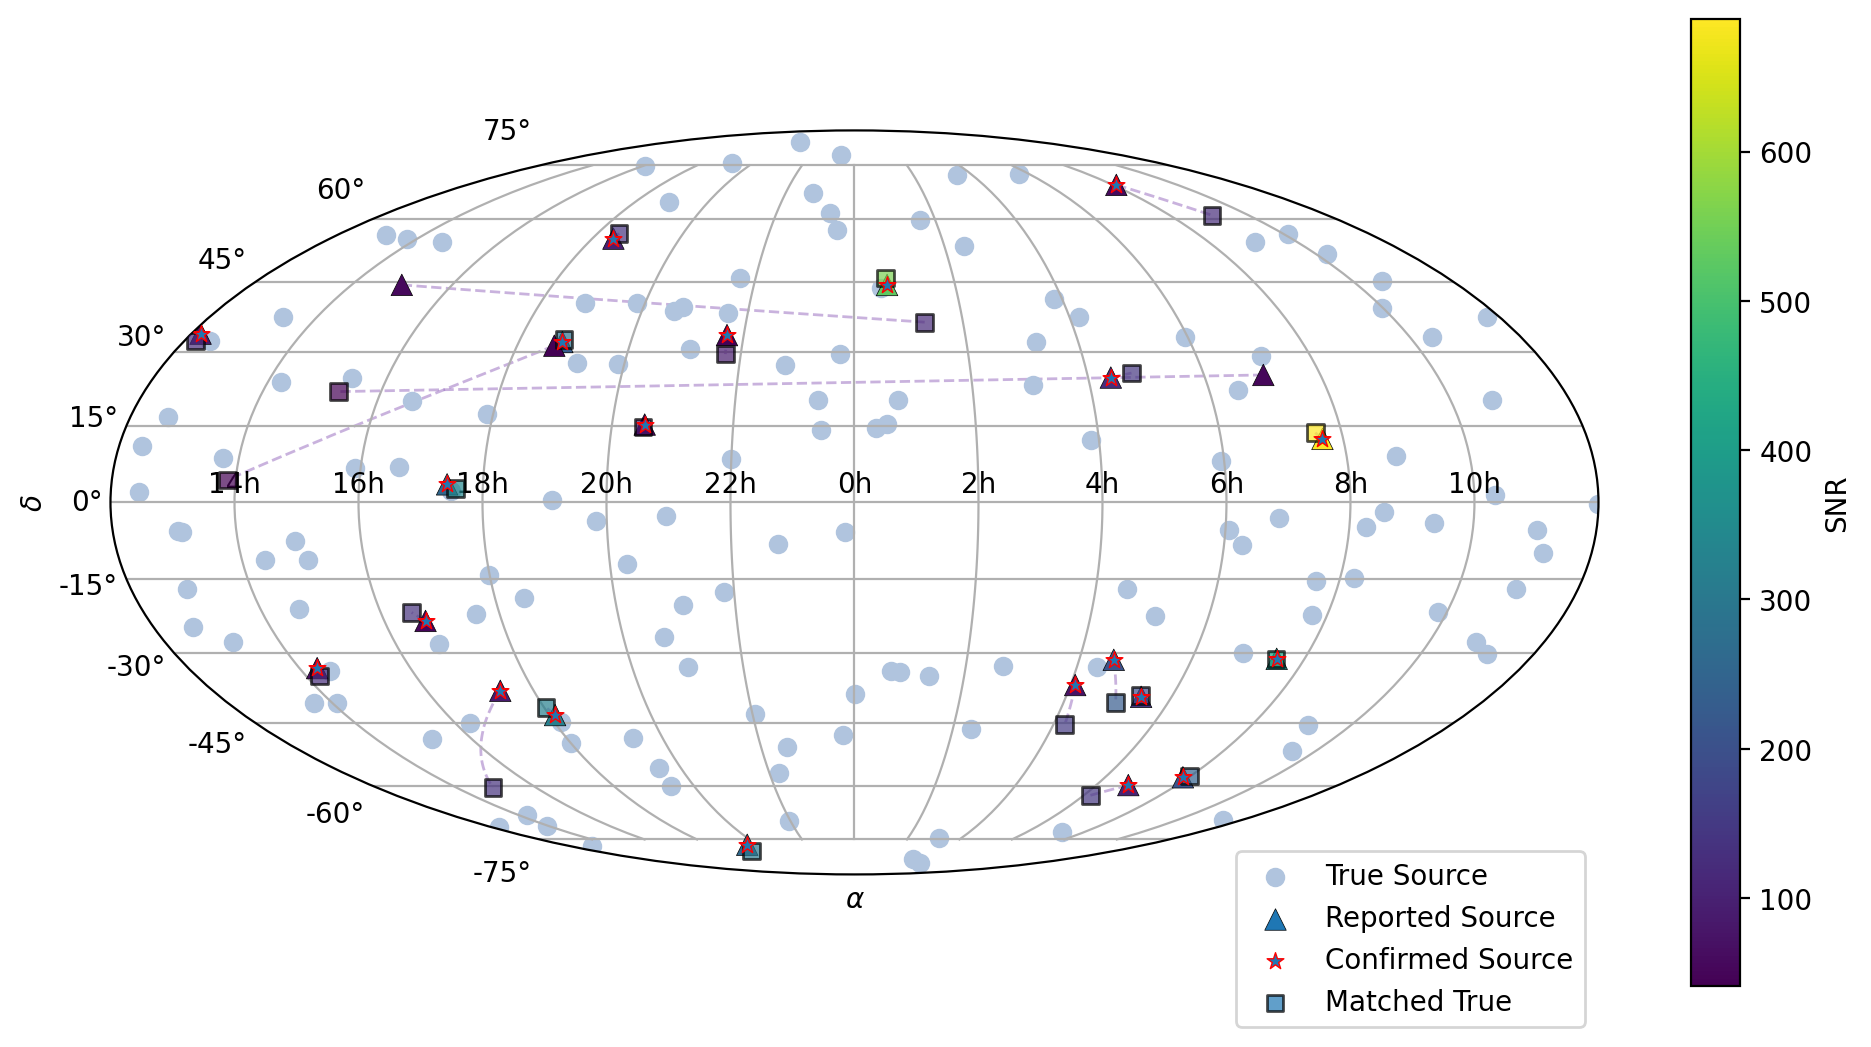

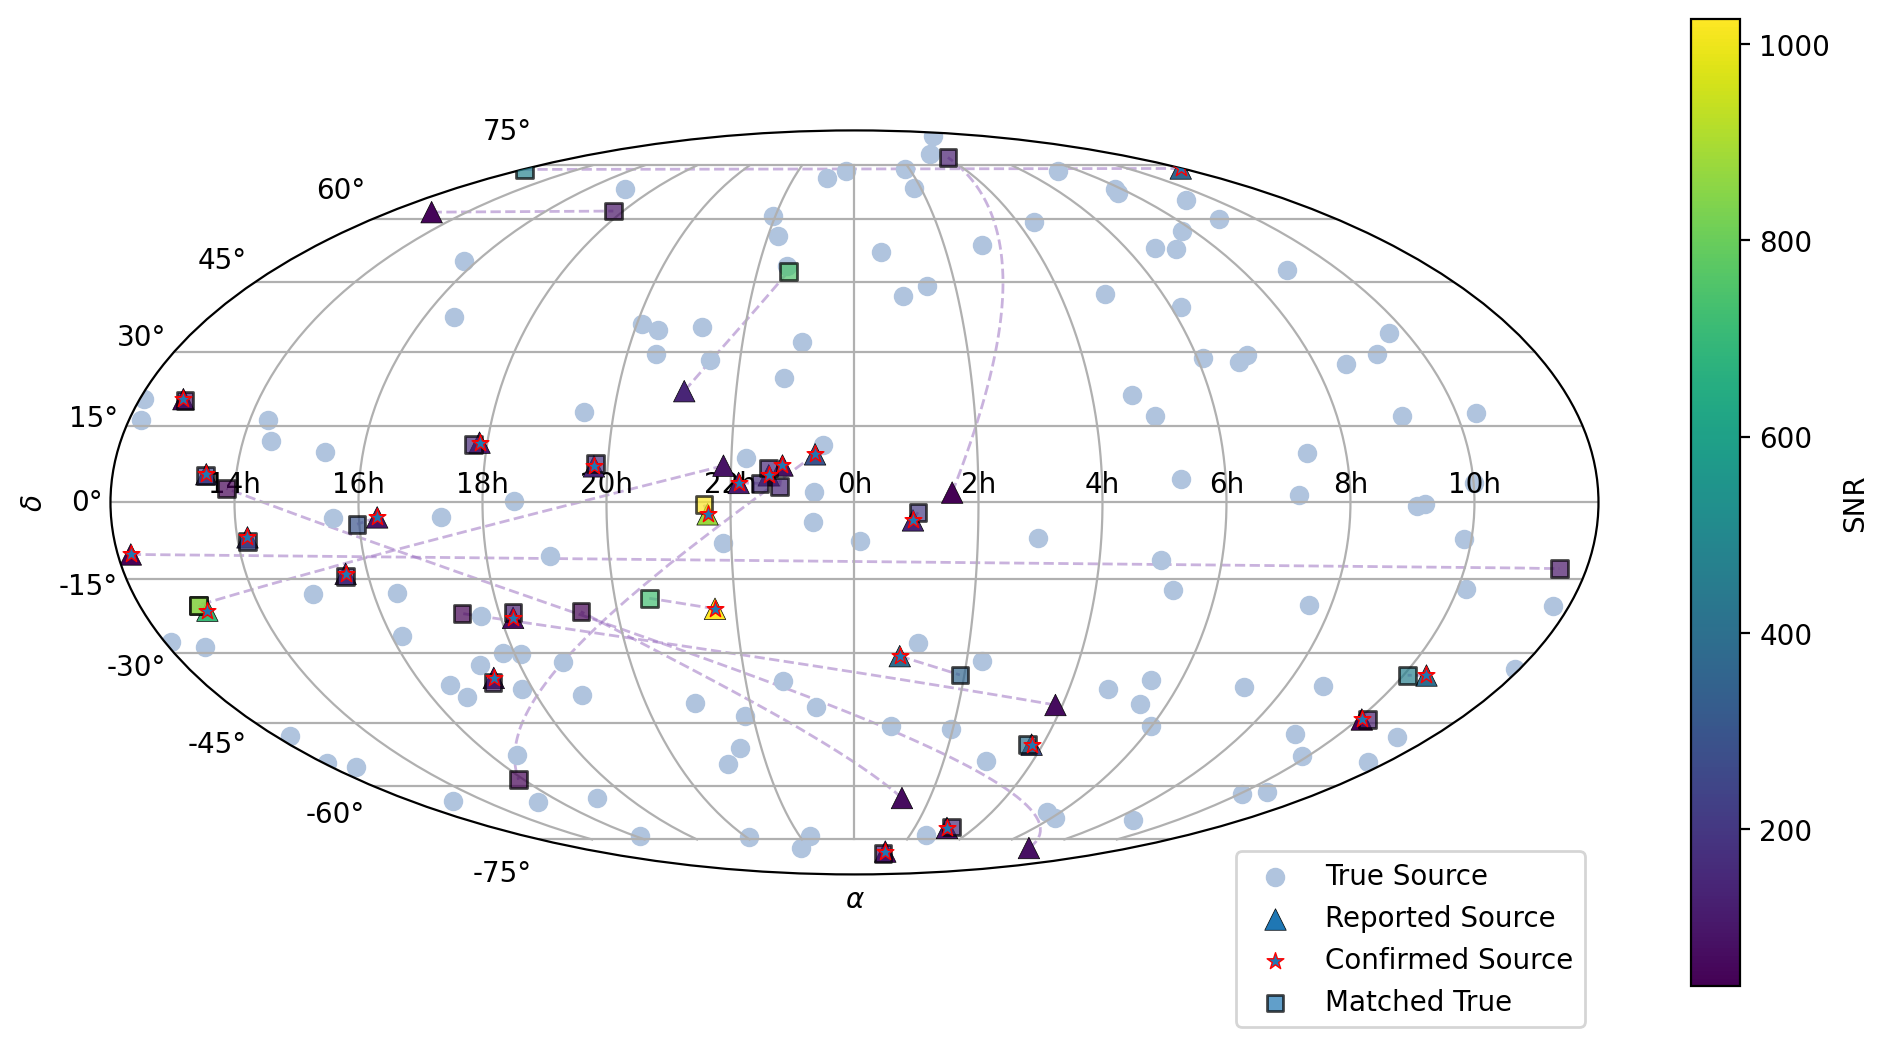

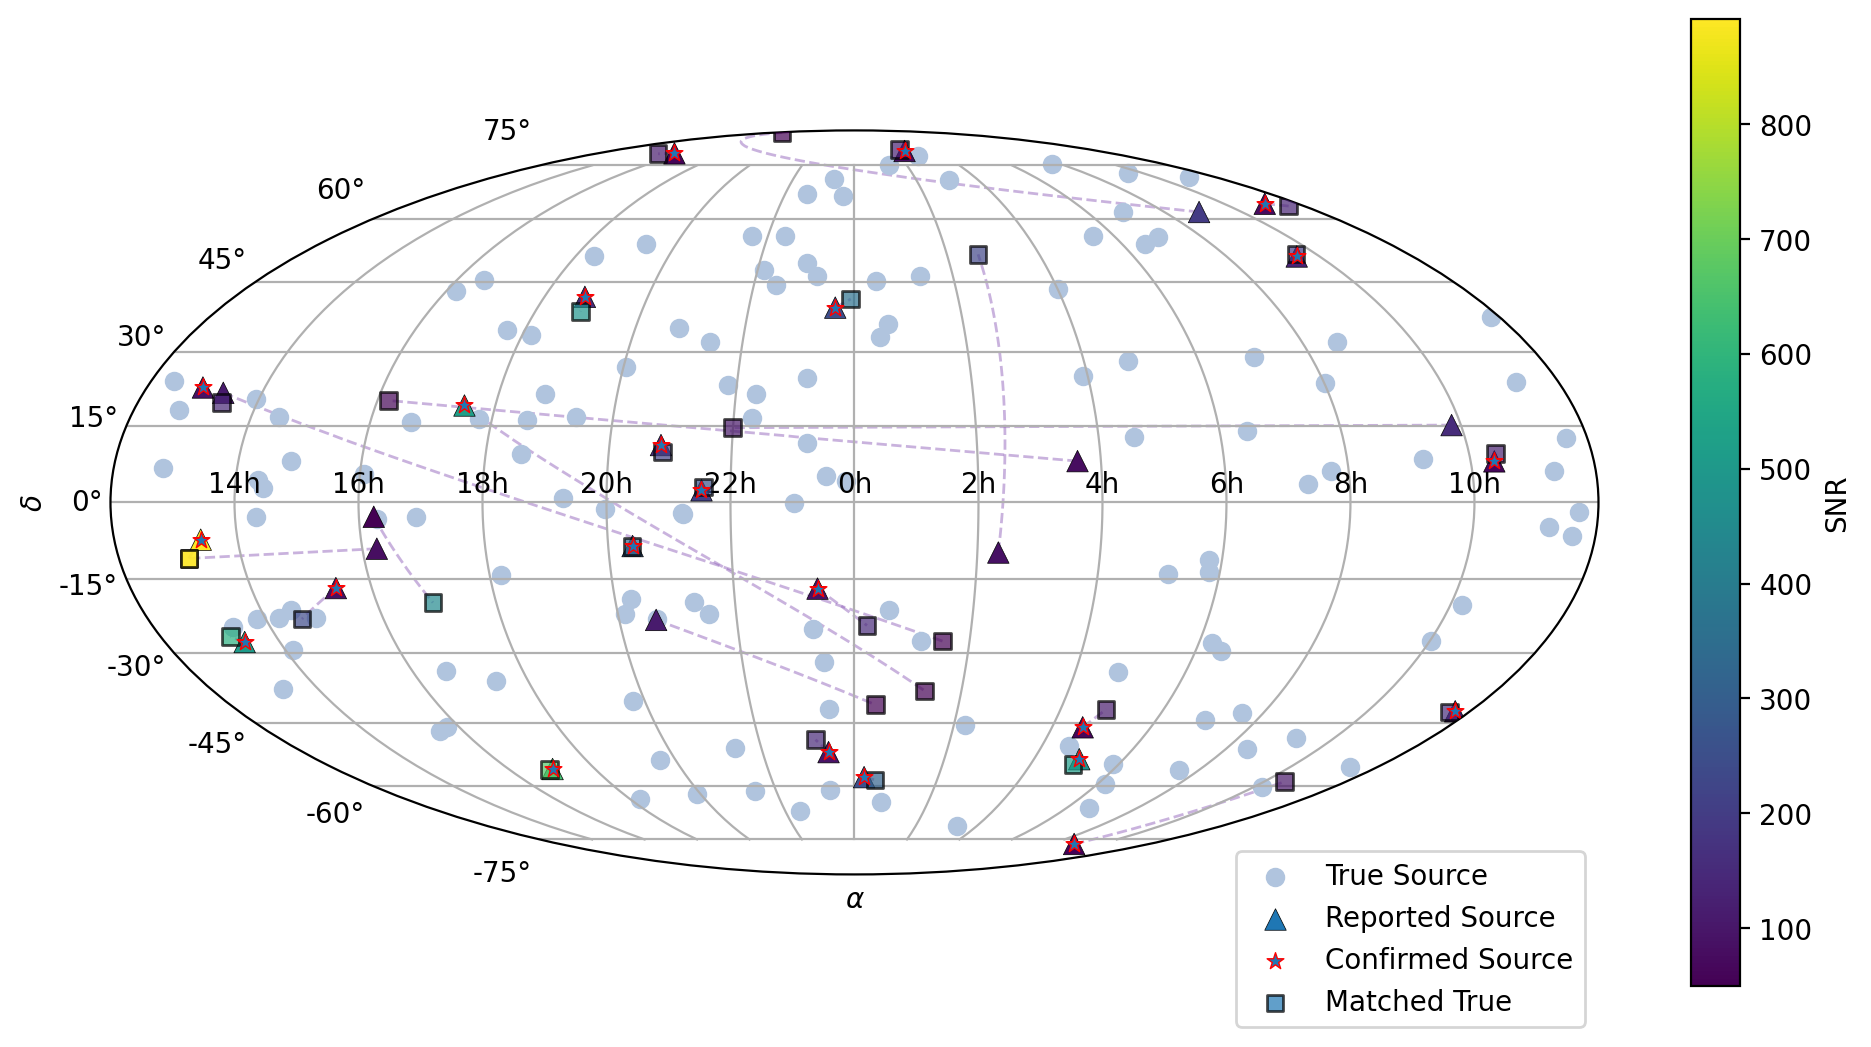

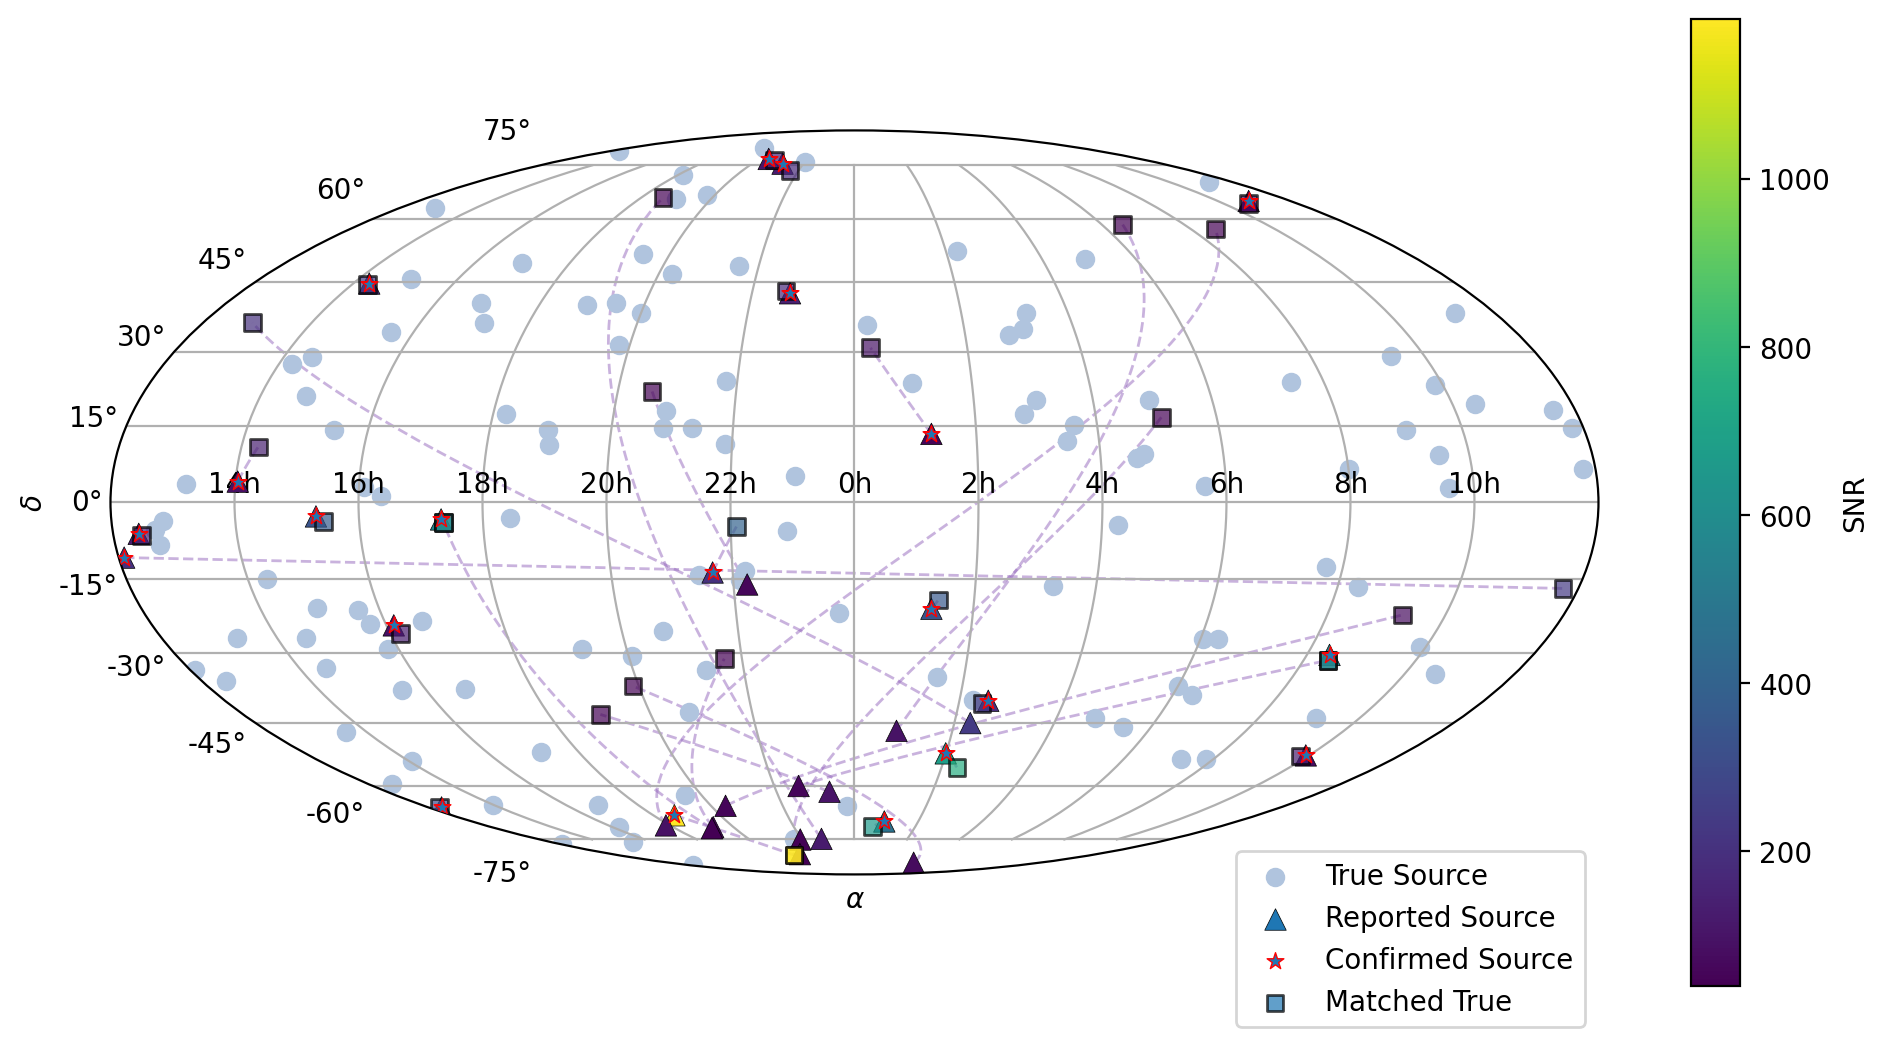

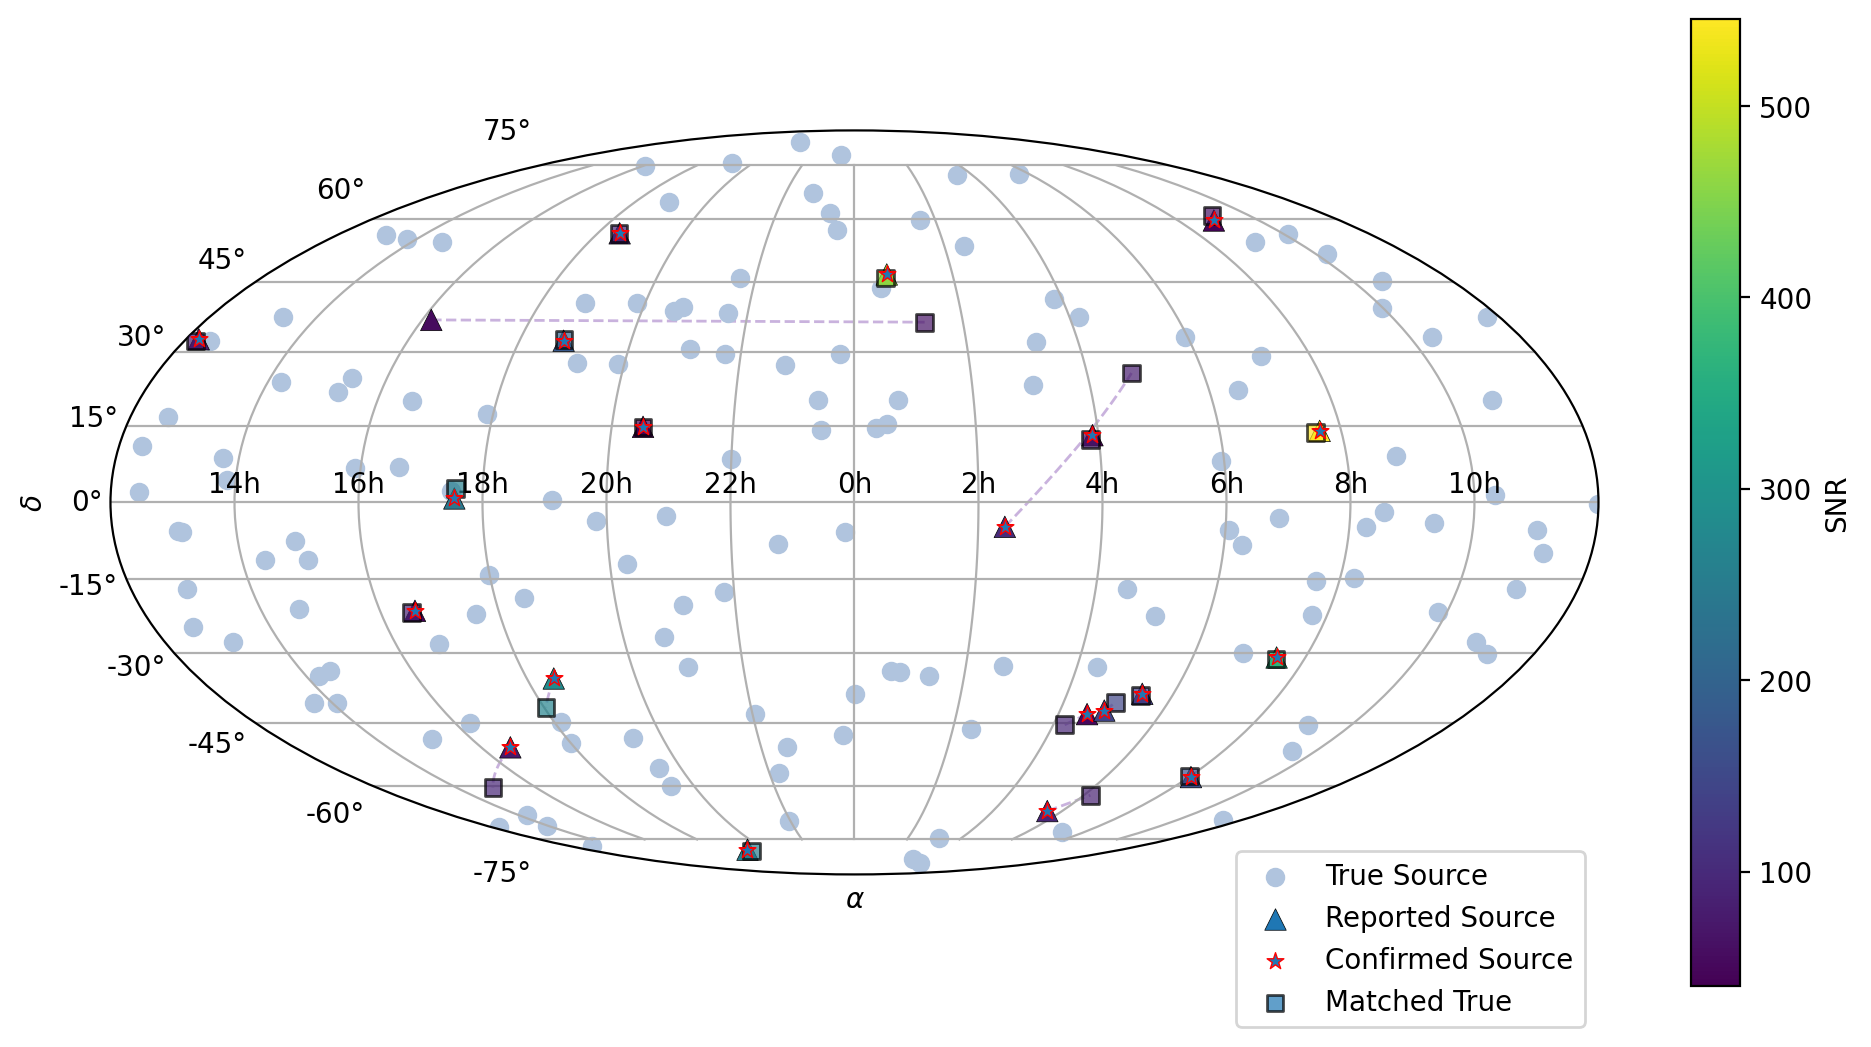

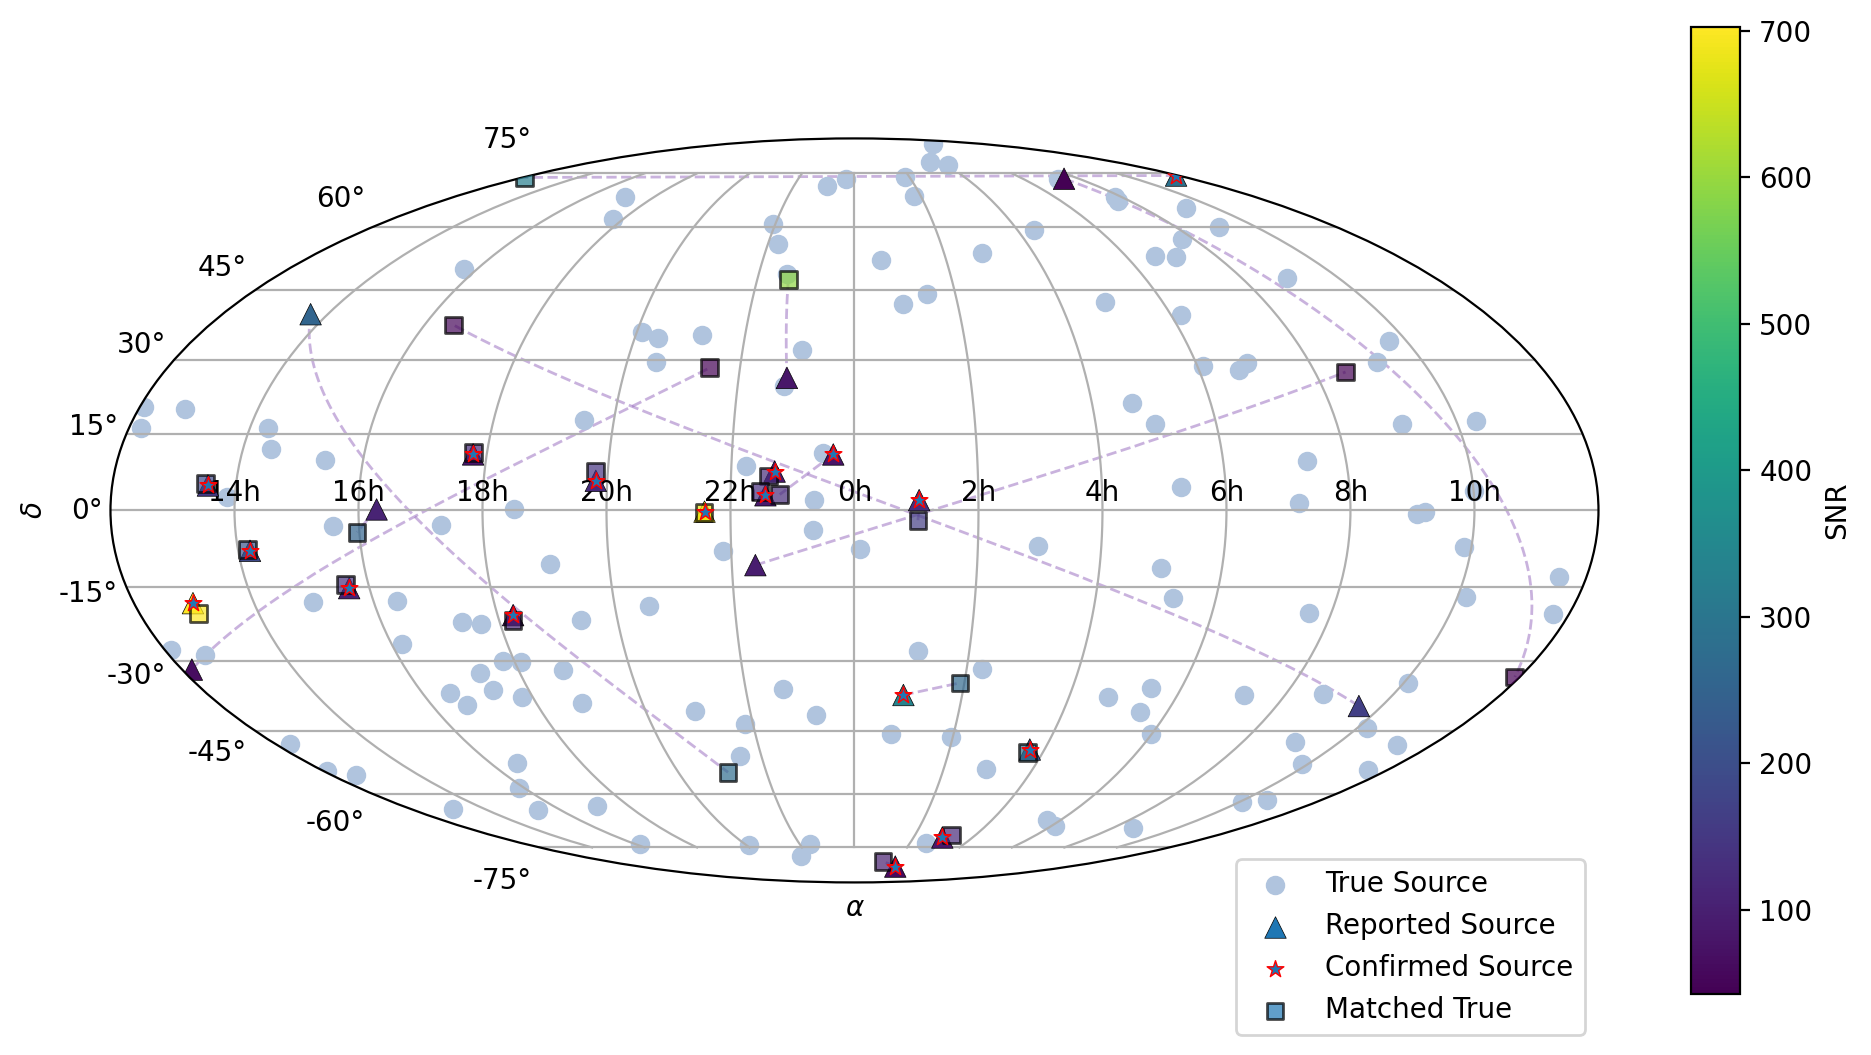

In [26]:
snr_threshold = 40
for rlz in range(len(rlzFiles)):
    repSrc = loadmat(estDir + rlzBaseName[rlz] + '/repSrc_sky' + str(snr_threshold) + '.mat')
    cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/CnfrmSrc_sky' + str(snr_threshold) + '.mat')
    matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky' + str(snr_threshold) + '.mat')
    simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky' + str(snr_threshold) + '.mat')
    # assign variables
    repRA = repSrc['repRA']
    repDec = repSrc['repDec']
    repSNR = repSrc['repSNR']
    cnfrmRA = cfrSrc['idRA']
    cnfrmDec = cfrSrc['idDec']
    cnfrmSNR = cfrSrc['idSNR']
    matRA = matSrc['matched_alpha_rep']
    matDec = matSrc['matched_dec_rep']
    matSNR = matSrc['matched_snr_rep']
    simRA_nm = simSrc_nm['simRA_nm']
    simDec_nm = simSrc_nm['simDec_nm']
    # create detection rate reports
    detection_rate = cnfrmDec.size / repDec.size
    min_snr = min(repSNR[0])
    with open(estDir + 'fig/' + 'detection_rate.txt','a') as f:
        f.write(f'{rlzBaseName[rlz]} reported {len(repSNR[0])} sources, confirmed {len(cnfrmSNR[0])} sources, the detection rate is {len(cnfrmSNR[0])/ len(repSNR[0])}, the SNR threshold is {snr_threshold}, lowest reported SNR is {min(repSNR[0])}')
        f.write('\n')
    
    # plot Mollweide projections
    fig = plt.figure(figsize=(12,8),dpi=200)
    ax = fig.add_subplot(111, projection='mollweide')
    xlab = ['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h']

    alpha_rep = coord.Angle(repRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_cnfrm = coord.Angle(cnfrmRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_mat = coord.Angle(matRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_sim_nm = coord.Angle(simRA_nm * units.rad).wrap_at(180 * units.degree).radian

    f1 = ax.scatter(alpha_sim_nm,simDec_nm,label='True Source', zorder=1, color='lightsteelblue')
    f2 = ax.scatter(alpha_rep,repDec,c=repSNR,cmap='viridis',marker='^',s=60,edgecolor='k',lw=.25,label='Reported Source', zorder=2)    # using up triangle for reported sources
    f3 = ax.scatter(alpha_cnfrm,cnfrmDec,marker='*',s=40,edgecolor='r',label='Confirmed Source', lw=0.5, zorder=4) # star for   confirmed sources
    f4 = ax.scatter(alpha_mat,matDec,c=matSNR,cmap='viridis',marker='s',edgecolor='k', label='Matched True',alpha=0.7, zorder=3) #  square for matched true sources

    for i in range(len(repRA[0])):
        plt.plot([alpha_rep[0][i], alpha_mat[0][i]],[repDec[0][i], matDec[0][i]], ls='--', lw=1, color = 'C4', alpha=0.5,
        zorder=0)

    ax.set_xticklabels(xlab)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\delta$')
    ax.grid(True)
    fig.colorbar(f2,shrink=0.8, label='SNR')
    ax.legend(bbox_to_anchor=(1.0,.05))
    fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide' + str(snr_threshold) + '.png',dpi=300,facecolor='white')